# Phase curve fitting
Insipred by: https://github.com/rubin-dp0/tutorial-notebooks/blob/main/DP03_04b_Advanced_Phase_Curve_Modeling.ipynb

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import leastsq
import scienceplots
from photometric_models import HG, HG12, HG1G2
from db import query

plt.style.use('science')

filters = ['g', 'r', 'i', 'z']
filter_colors = {'g': '#008060', 'r': '#ff4000', 'i': '#850000', 'z': '#6600cc'}
linestyles = {'g': "--", "r":"-.", "i":":", "z":"-"}


In [2]:
def weighted_dev(params, mag, phase, mag_err, model):
    """
    Compute weighted deviation for a given model.
    
    Parameters
    ----------
    params: list
        phase curve parameters
    mag: ndarray
        reduced magnitude
    phase: ndarray
        phase angle in radians
    mag_err: ndarray
        uncertainty in magnitude
    model: function
        phase curve model function
    

    Returns
    -------
    sol: tuple
        best-fit solution
    """

    pred = model(phase, params)

    return (mag - pred)/mag_err

def fitPhaseCurve(mag, phase, sigma, model=HG12, params=[0.1]):
    """
    Fit phase curve for given observations to a designated model.

    Parameters
    ----------
    mag: ndarray
        reduced magnitude
    phase: ndarray
        phase angle in degrees
    sigma: ndarray
        uncertainty in magnitude
    model: function (default=HG12_model)
        phase curve model function
    params: list (default=[0.1])
        phase curve parameters

    Returns
    -------
    sol: tuple
        best-fit solution
    """

    phase = np.deg2rad(phase)
    sol = leastsq(weighted_dev, [mag[0]] + params, (mag, phase, sigma, model),
                  full_output=True)

    return sol

def fitAllPhaseCurveModels(reducedMag, magSigma, phaseAngle, verbose=False):
    """
    Fit phase curves for given observations to three different models,
    the HG (sol_HG), HG12 (sol_HG12) and HG1G2 (sol_HG1G2), and 
    store the resulting solutions in a dictionary of dictionaries. 
    Save np.nan values when the fit is not converged.

    Parameters
    ----------
    reducedMag: ndarray
        reduced magnitude
    magSigma: ndarray
        uncertainty in magnitude
    phaseAngle: ndarray
        phase angle in degrees

    Returns
    -------
    solutions: dict
        Best-fit solutions for each model
    """

    solutions = {}

    sol_HG = fitPhaseCurve(reducedMag, phaseAngle, magSigma, model=HG)

    solutions['HG'] = {}
    try:
        solutions['HG']['chi2'] = np.sum(sol_HG[2]['fvec']**2)
        solutions['HG']['H'] = sol_HG[0][0]
        solutions['HG']['G'] = sol_HG[0][1]
        solutions['HG']['H_err'] = np.sqrt(sol_HG[1][0, 0])
        solutions['HG']['G_err'] = np.sqrt(sol_HG[1][1, 1])
        solutions['HG']['cov'] = sol_HG[1]
    except TypeError:
        if verbose:
            print('HG model is not converging')
        solutions['HG']['chi2'] = np.nan
        solutions['HG']['H'] = np.nan
        solutions['HG']['G'] = np.nan
        solutions['HG']['H_err'] = np.nan
        solutions['HG']['G_err'] = np.nan
        solutions['HG']['cov'] = np.nan

    sol_HG12 = fitPhaseCurve(reducedMag, phaseAngle,
                             magSigma, model=HG12)

    solutions['HG12'] = {}
    try:
        solutions['HG12']['chi2'] = np.sum(sol_HG12[2]['fvec']**2)
        solutions['HG12']['H'] = sol_HG12[0][0]
        solutions['HG12']['G12'] = sol_HG12[0][1]
        solutions['HG12']['H_err'] = np.sqrt(sol_HG12[1][0, 0])
        solutions['HG12']['G12_err'] = np.sqrt(sol_HG12[1][1, 1])
        solutions['HG12']['cov'] = sol_HG12[1]
    except TypeError:
        if verbose:
            print('HG12 model is not converging')
        solutions['HG12']['chi2'] = np.nan
        solutions['HG12']['H'] = np.nan
        solutions['HG12']['G12'] = np.nan
        solutions['HG12']['H_err'] = np.nan
        solutions['HG12']['G12_err'] = np.nan
        solutions['HG12']['cov'] = np.nan

    sol_HG1G2 = fitPhaseCurve(reducedMag, phaseAngle, magSigma,
                              model=HG1G2, params=[0.1, 0.1])

    solutions['HG1G2'] = {}
    try:
        solutions['HG1G2']['chi2'] = np.sum(sol_HG1G2[2]['fvec']**2)
        solutions['HG1G2']['H'] = sol_HG1G2[0][0]
        solutions['HG1G2']['G1'] = sol_HG1G2[0][1]
        solutions['HG1G2']['G2'] = sol_HG1G2[0][2]
        solutions['HG1G2']['H_err'] = np.sqrt(sol_HG1G2[1][0, 0])
        solutions['HG1G2']['G1_err'] = np.sqrt(sol_HG1G2[1][1, 1])
        solutions['HG1G2']['G2_err'] = np.sqrt(sol_HG1G2[1][2, 2])
        solutions['HG1G2']['cov'] = sol_HG1G2[1]
    except TypeError:
        if verbose:
            print('HG1G2 model is not converging')
        solutions['HG1G2']['chi2'] = np.nan
        solutions['HG1G2']['H'] = np.nan
        solutions['HG1G2']['G1'] = np.nan
        solutions['HG1G2']['G2'] = np.nan
        solutions['HG1G2']['H_err'] = np.nan
        solutions['HG1G2']['G1_err'] = np.nan
        solutions['HG1G2']['G2_err'] = np.nan
        solutions['HG1G2']['cov'] = np.nan

    return solutions

In [3]:
nobs_thrh = '2000'
min_a = '2.0'
max_a = '3.2'
min_q = '1.666'

stmt = """
SELECT
    mpc.ssObjectId, mpc.mpcG, mpc.mpcH,
    mpc.q/(1-mpc.e) as a,
    sso.arc, sso.numObs,
    sso.g_H, sso.g_Herr, sso.g_G12, sso.g_G12err, sso.g_H_gG12_Cov,
    sso.r_H, sso.r_Herr, sso.r_G12, sso.r_G12err, sso.r_H_rG12_Cov,
    sso.i_H, sso.i_Herr, sso.i_G12, sso.i_G12err, sso.i_H_iG12_Cov,
    sso.z_H, sso.z_Herr, sso.z_G12, sso.z_G12err, sso.z_H_zG12_Cov
FROM
    dp03_catalogs_10yr.MPCORB as mpc
INNER JOIN dp03_catalogs_10yr.SSObject as sso
ON mpc.ssObjectId = sso.ssObjectId
WHERE sso.numObs > {} AND mpc.q/(1-mpc.e) > {} AND
mpc.q/(1-mpc.e) < {} AND mpc.q > {} ORDER by sso.ssObjectId
""".format(nobs_thrh, min_a, max_a, min_q)

uniqueObj = query(stmt).to_table()
uniqueObj

ssObjectId,mpcG,mpcH,a,arc,numObs,g_H,g_Herr,g_G12,g_G12err,g_H_gG12_Cov,r_H,r_Herr,r_G12,r_G12err,r_H_rG12_Cov,i_H,i_Herr,i_G12,i_G12err,i_H_iG12_Cov,z_H,z_Herr,z_G12,z_G12err,z_H_zG12_Cov
,,mag,,d,,mag,mag,mag,mag,mag2,mag,mag,mag,mag,mag2,mag,mag,mag,mag,mag2,mag,mag,mag,mag,mag2
int64,float32,float32,object,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
-9217466392671047318,0.15,14.48,2.7534679055396287,3099.2915,2866,15.203103,0.00038897144,0.4550666,0.0040478734,7.9422597e-07,14.554703,0.00021039916,0.48015854,0.0020262992,1.7115104e-07,14.354623,0.00025000537,0.4709413,0.0025779733,2.3757198e-07,14.407989,0.0006071515,0.51356506,0.005866336,1.1365114e-06
-9186168674478550259,0.15,15.54,2.735597883342819,2920.819,2064,16.26421,0.0009085277,0.5034483,0.009313577,3.7164054e-06,15.6143055,0.00045167241,0.5149425,0.0049309437,1.8081512e-07,15.414917,0.0005772725,0.50797635,0.00510145,7.0264207e-07,15.471048,0.0011641541,0.5433281,0.009459758,1.9743543e-06
-9023703058184288186,0.15,16.64,2.940021025169084,2817.7273,2331,17.358274,0.0035483497,0.50554883,0.036873408,7.245376e-05,16.716164,0.001927695,0.5128336,0.018558158,2.0433228e-05,16.515278,0.0023644213,0.4923302,0.024016123,3.2025448e-05,16.568754,0.005117289,0.5263797,0.04942868,0.00014278179
-8991757915344909776,0.15,18.32,2.712164954223674,2911.9167,2027,19.041605,0.0039131506,0.49194965,0.038261477,2.652303e-05,18.39314,0.0022384885,0.46744,0.020893808,1.3363821e-05,18.197392,0.0027081787,0.5020755,0.026521428,1.2971898e-05,18.232428,0.00799786,0.31482488,0.08765045,0.0002543192
-8983147311557262481,0.15,16.81,3.1285476112080075,3223.7615,2103,17.358887,0.0022244945,0.5284655,0.028648542,1.4641261e-05,16.87871,0.0015134424,0.5128175,0.018769464,6.977196e-06,16.761572,0.001905264,0.5324352,0.025683051,7.7371615e-06,16.753658,0.0048452453,0.46961442,0.05186777,0.00012877512
-8941112935633645120,0.15,17.46,2.4713281790115262,3111.7393,2357,18.188131,0.0013846699,0.5111664,0.011265048,8.2808214e-07,17.539248,0.0007647462,0.48283827,0.005792018,3.7366075e-07,17.337635,0.0010335406,0.5097,0.007862881,-1.0053393e-06,17.386505,0.0027831802,0.5375992,0.025589064,-2.3151732e-05
-8926263449476792198,0.15,16.98,2.603187433175253,3454.771,2145,17.701952,0.0016780668,0.49290684,0.017006207,-1.5563393e-06,17.05407,0.0009794187,0.46493313,0.00934684,4.142698e-07,16.85306,0.0011744339,0.48502782,0.011868707,-9.0575486e-07,16.907093,0.0032809514,0.50106376,0.031326078,3.8512946e-05
-8898442558843979238,0.15,18.23,2.540751939505157,3007.7913,2022,18.774021,0.0023720781,0.5111807,0.017291997,1.17132095e-05,18.30697,0.0015417456,0.4712598,0.010613613,5.945477e-06,18.186533,0.0020921014,0.49740168,0.015085877,7.081695e-06,18.17325,0.004575927,0.5023939,0.031217633,3.5207522e-05


In [4]:
stmt = """
SELECT
    dia.ssObjectId, dia.diaSourceId, dia.mag,
    dia.magErr, dia.band, dia.midPointMjdTai,
    sss.phaseAngle, sss.topocentricDist, sss.heliocentricDist
FROM
    dp03_catalogs_10yr.DiaSource as dia
INNER JOIN
    dp03_catalogs_10yr.SSSource as sss
ON
    dia.diaSourceId = sss.diaSourceId
WHERE
    dia.ssObjectId
    IN {}
ORDER by dia.ssObjectId
""".format(tuple(uniqueObj['ssObjectId']))

indivObs = query(stmt).to_table()
indivObs

ssObjectId,diaSourceId,mag,magErr,band,midPointMjdTai,phaseAngle,topocentricDist,heliocentricDist
,,,,,d,deg,AU,AU
int64,int64,float32,float32,str1,float64,float32,float32,float32
-9217466392671047318,5074726492115737,20.055,0.012,r,61021.35247,17.301477,2.711414,3.1537251
-9217466392671047318,19481485662802488,19.669,0.007,i,61033.2511,15.801364,2.5499394,3.1503248
-9217466392671047318,39913165364548592,20.21,0.009,r,61010.34128,18.036163,2.8695178,3.1563327
-9217466392671047318,48327202766987632,19.45,0.01,z,61049.34712,12.501292,2.3604758,3.14477
-9217466392671047318,48371439483286632,19.711,0.008,i,61031.33981,16.094881,2.5749133,3.1509116
-9217466392671047318,62341640397910521,20.195,0.008,g,61051.17905,12.03446,2.3417952,3.144068
-9217466392671047318,73744426738833766,20.075,0.016,i,61005.35388,18.184,2.9424236,3.1573431
-9217466392671047318,75023334125204409,20.044,0.014,r,61021.3483,17.301888,2.711473,3.1537263


In [5]:
assert len(uniqueObj) == len(np.unique(indivObs['ssObjectId']))

Fitting the phase curves - from scratch

In [6]:
def reduced_magnitude(m, hd, td):
    return m - 5.0*np.log10(hd*td)

In [12]:
indivObs.add_column(reduced_magnitude(indivObs['mag'], indivObs['topocentricDist'], indivObs['heliocentricDist']), name='reducedMag')
indivObs.add_column(reduced_magnitude(indivObs['magErr'], indivObs['topocentricDist'], indivObs['heliocentricDist']), name='reducedMagErr')

In [20]:
fitted_array = []

for iobj in uniqueObj['ssObjectId']:
    idx = indivObs['ssObjectId'] == iobj
    tmp = indivObs[idx]
    filts_tmp = np.unique(tmp['band'])
    for ifilt in filts_tmp:
        idx_filt = tmp['band'] == ifilt
        nobs_ifilt = len(tmp[idx_filt])

        if nobs_ifilt > 3:
            x_fitted = fitAllPhaseCurveModels(tmp['reducedMag'][idx_filt],
                                              tmp['magErr'][idx_filt],
                                              tmp['phaseAngle'][idx_filt])
            fitted_array.append([iobj, ifilt, x_fitted])

results = pd.DataFrame(fitted_array)
results.columns = ['ssObjectId', 'fname', 'fit_param']

L = ['ssObjectId', 'fname']
results = results[L].join(pd.json_normalize(results.fit_param))

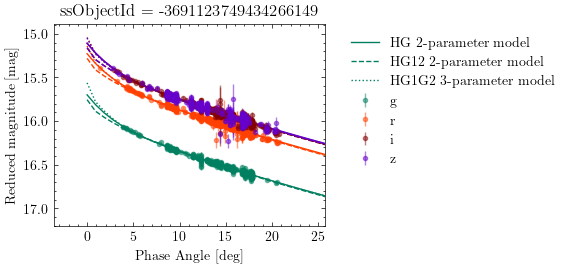

In [21]:
iObj = 100
sId = uniqueObj['ssObjectId'][iObj]
tmp = indivObs[indivObs['ssObjectId'] == sId]
phases = np.linspace(0, 90, 100)

for i, ifilt in enumerate(filters):
    idx = tmp['band'] == ifilt
    if i==0:
        labels = ['HG 2-parameter model',
                  'HG12 2-parameter model', 
                  'HG1G2 3-parameter model'
                 ]
    else:
        labels = [None, None, None]

    plt.errorbar(tmp['phaseAngle'][idx], tmp['reducedMag'][idx],
                 yerr=tmp['magErr'][idx], fmt='.',
                 color=filter_colors[ifilt], alpha=0.5, label=ifilt)

    HG_mag = HG(np.deg2rad(phases),
                      [results[(results.ssObjectId == sId)
                               & (results.fname == ifilt)]['HG.H'].values,
                       results[(results.ssObjectId == sId)
                               & (results.fname == ifilt)]['HG.G'].values])
    plt.plot(phases, HG_mag, color=filter_colors[ifilt],
             label=labels[0])

    HG12_mag = HG12(np.deg2rad(phases),
                          [results[(results.ssObjectId == sId)
                                   & (results.fname == ifilt)]['HG12.H'].values,
                           results[(results.ssObjectId == sId)
                                   & (results.fname == ifilt)]['HG12.G12'].values])
    plt.plot(phases, HG12_mag, color=filter_colors[ifilt], linestyle='--',
             label=labels[1])

    HG1G2_mag = HG1G2(np.deg2rad(phases),
                            [results[(results.ssObjectId == sId)
                                     & (results.fname == ifilt)]['HG1G2.H'].values,
                             results[(results.ssObjectId == sId)
                                     & (results.fname == ifilt)]['HG1G2.G1'].values,
                             results[(results.ssObjectId == sId)
                                     & (results.fname == ifilt)]['HG1G2.G2'].values])
    plt.plot(phases, HG1G2_mag, color=filter_colors[ifilt], linestyle='dotted',
             label=labels[2])

plt.xlim(tmp['phaseAngle'].min()-5, tmp['phaseAngle'].max()+5)
plt.ylim(tmp['reducedMag'].max()+0.5, tmp['reducedMag'].min()-0.5)
plt.xlabel('Phase Angle [deg]')
plt.ylabel('Reduced magnitude [mag]')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.title('ssObjectId = %d' % sId)
plt.show()

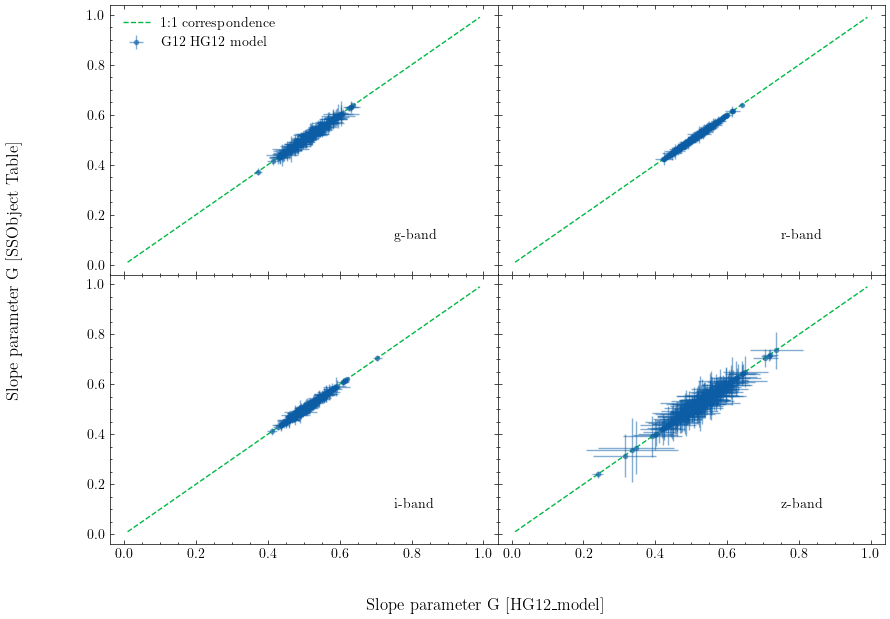

In [22]:
fig = plt.figure(figsize=(10, 7))
gs = fig.add_gridspec(2, 2, wspace=0, hspace=0)
axs = gs.subplots(sharex=True, sharey=True)
axs = axs.ravel()

one2one = np.arange(0.01, 1, .01)
filts = ['g', 'r', 'i', 'z']
for i, ifilt in enumerate(filts):

    axs[i].errorbar(results[results.fname == ifilt]['HG12.G12'],
                    uniqueObj[ifilt+'_G12'],
                    xerr=results[results.fname == ifilt]['HG12.G12_err'],
                    yerr=uniqueObj[ifilt+'_G12err'], fmt='.', alpha=0.5,
                    label='G12 HG12 model')

    axs[i].plot(one2one, one2one, '--', label='1:1 correspondence')
    axs[i].text(0.75, 0.1, ifilt+'-band')

fig.supxlabel('Slope parameter G [HG12_model]')
fig.supylabel('Slope parameter G [SSObject Table]')
axs[0].legend(loc=2)
plt.show()

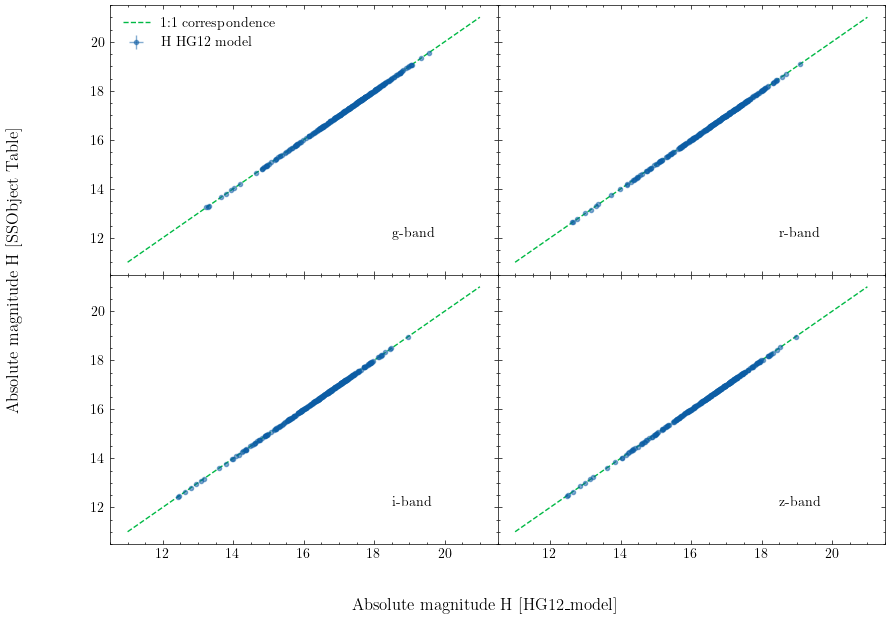

In [23]:
fig = plt.figure(figsize=(10, 7))
gs = fig.add_gridspec(2, 2, wspace=0, hspace=0)
axs = gs.subplots(sharex=True, sharey=True)
axs = axs.ravel()

one2one = np.arange(11, 22, 1)
for i, ifilt in enumerate(filts):

    axs[i].errorbar(results[results.fname == ifilt]['HG12.H'],
                    uniqueObj[ifilt+'_H'],
                    xerr=results[results.fname == ifilt]['HG12.H_err'],
                    yerr=uniqueObj[ifilt+'_Herr'], fmt='.', alpha=0.5,
                    label='H HG12 model')

    axs[i].plot(one2one, one2one, '--', label='1:1 correspondence')
    axs[i].text(18.5, 12, ifilt+'-band')

fig.supxlabel('Absolute magnitude H [HG12_model]')
fig.supylabel('Absolute magnitude H [SSObject Table]')
axs[0].legend(loc=2)
plt.show()

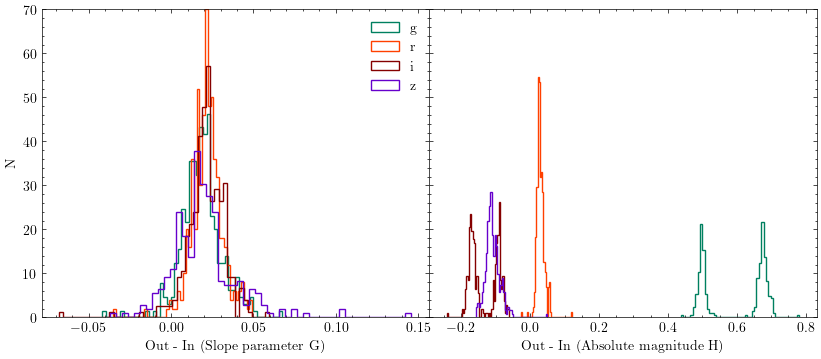

In [24]:
fig = plt.figure(figsize=(10, 4))
gs = fig.add_gridspec(1, 2, wspace=0)
axs = gs.subplots(sharey=True)
axs = axs.ravel()

one2one = np.arange(0.01, 1, .01)
for i, ifilt in enumerate(filters):

    h = axs[0].hist(results[results.fname == ifilt]['HG.G']
                    - uniqueObj['mpcG'], bins=50, density=True,
                    histtype='step', color=filter_colors[ifilt], label=ifilt)

    h = axs[1].hist(results[results.fname == ifilt]['HG.H']
                    - uniqueObj['mpcH'], bins=50, density=True,
                    histtype='step', color=filter_colors[ifilt])


axs[0].set_xlabel('Out - In (Slope parameter G)')
axs[0].set_ylabel('N')
'''axs[0].plot([0, 0], [0, 80], 'k--',label='zero bias')
axs[0].plot([0.02, 0.02], [0, 80], 'k',label='detected bias')'''
axs[0].set_ylim(0, 70)
axs[0].legend(loc=1)
axs[1].set_xlabel('Out - In (Absolute magnitude H)')
plt.show()